In [1]:
import pandas as pd
import numpy as np

In [2]:
df_results0 = pd.read_csv(r"../data/naacl-woah-results/sample_500_run_gemini_naacl.csv", delimiter=",", on_bad_lines="skip")

In [3]:
df_results0.head()

,original_id,original_input,label,gemini_resp,language,task
0,2619,"რაც ""ნაციონალურმა მოძრაობამ"" 8 წელიწადში აჭარა...",true,50,ka,gemini-zero-shot-100-threshold
1,456,Przez ostatni rok bezrobocie osiągnęło w Niemc...,true,80,pl,gemini-zero-shot-100-threshold
2,102,Os estados onde você teve a maior piora no nív...,false,50,pt,gemini-zero-shot-100-threshold
3,3037,Foto Unjuk Rasa Driver Go-Jek Hasil Suntingan,partly true/misleading,100,id,gemini-zero-shot-100-threshold
4,1126,Orientações de prevenção ao corona vírus (sic)...,false,0,pt,gemini-zero-shot-100-threshold


In [4]:
#remove other and complicated labels 
# df_results0 = df_results0[~df_results0['label'].isin(['complicated/hard to categorise', 'other'])]


In [5]:
df_results0.shape

(499, 6)

In [6]:
def simplify_truth(row):
    if row['label'] in ['false', 'mostly false', 'partly true/misleading']: #TODO: tune these
        return 0
    else:
        return 1

    
    # if row['label']=='true':
    #     return 1
    # else: return 0
    # # if row['label'] in ['false', 'mostly false', 'partly true/misleading']: #TODO: tune these
    # #     return 'false'
    # # else:
    # #     return 'true'
    

df_results0['simple_truth'] = df_results0.apply(simplify_truth, axis=1)

df_results0["simple_truth"].value_counts() #much more false than true

simple_truth
0    306
1    193
Name: count, dtype: int64

In [8]:
def cohere_tv(row):
    resp = row['gemini_resp']
    try:
        resp = float(resp)
    except ValueError:
        return "unknown"
    
    if resp > 50: #TODO: tune this value?
        return 1
    
    else:
        return 0
    

df_results0['gemini_simple'] = df_results0.apply(cohere_tv, axis=1)
# print(df_results0.shape)
df_processed = df_results0.copy().drop(df_results0[(df_results0.gemini_simple != 0) & (df_results0.gemini_simple != 1)].index)
df_processed = df_processed.drop(df_processed[df_processed.label.isin(['complicated/hard to categorise', 'other', np.nan])].index)
df_processed = df_processed.reset_index()

In [9]:
df_processed.head()

,index,original_id,original_input,label,gemini_resp,language,task,simple_truth,gemini_simple
0,0,2619,"რაც ""ნაციონალურმა მოძრაობამ"" 8 წელიწადში აჭარა...",true,50,ka,gemini-zero-shot-100-threshold,1,0
1,1,456,Przez ostatni rok bezrobocie osiągnęło w Niemc...,true,80,pl,gemini-zero-shot-100-threshold,1,1
2,2,102,Os estados onde você teve a maior piora no nív...,false,50,pt,gemini-zero-shot-100-threshold,0,0
3,3,3037,Foto Unjuk Rasa Driver Go-Jek Hasil Suntingan,partly true/misleading,100,id,gemini-zero-shot-100-threshold,0,1
4,4,1126,Orientações de prevenção ao corona vírus (sic)...,false,0,pt,gemini-zero-shot-100-threshold,0,0


In [10]:
df_processed['simple_truth'].values.shape

(468,)

In [11]:
from sklearn.metrics import classification_report

### Overall Performance

In [13]:
print(classification_report(df_processed['simple_truth'].values.tolist(), df_processed['gemini_simple'].values.tolist()))

              precision    recall  f1-score   support

           0       0.75      0.64      0.69       305
           1       0.47      0.60      0.53       163

    accuracy                           0.62       468
   macro avg       0.61      0.62      0.61       468
weighted avg       0.65      0.62      0.63       468



In [14]:
def euro_or_not(lang):
    if lang in ["de", "es", "fr", "it", "no", "nl", "pl", "pt", "ro", "ru", "sr", "sq"]: #german, spanish, french, italian, norwegian, dutch, polish
        return True
    else: #ar - arabic; az - azerbaijani; bn - bengali; fa - farsi; gu - gujarati; hi - hindi; id - indonesian
        #ka - georgian; mr - marathi; pa - punjabi; si - sinhala; ta - tamil; tr - turkish
        return False

In [15]:
def conservative_true(label):
    if label in ['false', 'mostly false', 'partly true/misleading']: #TODO: tune these
        return 0
    else:
        return 1

In [16]:
df_processed.shape

(468, 9)

In [18]:
euro_y_true = []
euro_y_pred = []
non_euro_y_true = []
non_euro_y_pred = []
for i, rows in df_processed.iterrows():
    # print('hi')
    # print(i)
    # break
    # init_index = df_processed['index'][i]
    # if df_processed['label'][i]!=df_processed['label'][init_index]:
    #     pass
    #     # print(i, init_index)
    if euro_or_not(df_processed['language'][i]):
        euro_y_true.append(conservative_true(df_processed['label'][i]))
        euro_y_pred.append(df_processed['gemini_simple'][i])
    else:
        non_euro_y_true.append(conservative_true(df_processed['label'][i]))
        non_euro_y_pred.append(df_processed['gemini_simple'][i])

### Non-European vs European

In [19]:
print(classification_report(euro_y_true, euro_y_pred))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       144
           1       0.56      0.61      0.59       110

    accuracy                           0.63       254
   macro avg       0.62      0.62      0.62       254
weighted avg       0.63      0.63      0.63       254



In [20]:
print(classification_report(non_euro_y_true, non_euro_y_pred))

              precision    recall  f1-score   support

           0       0.82      0.63      0.72       161
           1       0.34      0.58      0.43        53

    accuracy                           0.62       214
   macro avg       0.58      0.61      0.57       214
weighted avg       0.70      0.62      0.65       214



### Western vs Non-Western

In [21]:
def western(lang):
    if lang in ["de", "es", "fr", "it", "nl", "no", "pt"]:
        return True
    else:
        return False

In [23]:
western_y_true = []
western_y_pred = []
non_western_y_true = []
non_western_y_pred = []
for i in range(df_processed.shape[0]):
    if western(df_processed['language'][i]):
        western_y_true.append(conservative_true(df_processed['label'][i]))
        western_y_pred.append(df_processed['gemini_simple'][i])
    else:
        non_western_y_true.append(conservative_true(df_processed['label'][i]))
        non_western_y_pred.append(df_processed['gemini_simple'][i])

In [24]:
print(classification_report(western_y_true, western_y_pred))

              precision    recall  f1-score   support

           0       0.68      0.65      0.67       107
           1       0.54      0.57      0.55        76

    accuracy                           0.62       183
   macro avg       0.61      0.61      0.61       183
weighted avg       0.62      0.62      0.62       183



In [25]:
print(classification_report(non_western_y_true, non_western_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.63      0.70       198
           1       0.43      0.63      0.51        87

    accuracy                           0.63       285
   macro avg       0.61      0.63      0.60       285
weighted avg       0.68      0.63      0.64       285



### Small vs Large

In [26]:
def small(lang):
    if lang in ["no", "nl", "pl", "ro", "sr", "sq", "az", "ka", "si"]:
        return True
    else: return False

In [27]:
small_y_true = []
small_y_pred = []
large_y_true = []
large_y_pred = []
for i in range(df_processed.shape[0]):
    if small(df_processed['language'][i]):
        small_y_true.append(conservative_true(df_processed['label'][i]))
        small_y_pred.append(df_processed['gemini_simple'][i])
    else:
        large_y_true.append(conservative_true(df_processed['label'][i]))
        large_y_pred.append(df_processed['gemini_simple'][i])

In [28]:
print(classification_report(small_y_true, small_y_pred))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62        59
           1       0.61      0.62      0.62        58

    accuracy                           0.62       117
   macro avg       0.62      0.62      0.62       117
weighted avg       0.62      0.62      0.62       117



In [29]:
print(classification_report(large_y_true, large_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.64      0.71       246
           1       0.41      0.59      0.49       105

    accuracy                           0.63       351
   macro avg       0.60      0.62      0.60       351
weighted avg       0.67      0.63      0.64       351



In [345]:
for i in df_processed['cohere_resp'].values:
    if float(i)<30:
        print(i)

15
25
8
25
19
22
10
16
16
10
20
16
15
25
0
10
15
25
16
15
16
20
8
8
12
15
10
16
16
25
22
10
10
8
25
25
22
12
0
15
16
12
0
15
25
28
25
15
23
16
25
0
0
8
8
12
12
15
16
12
25
15
15
15
16
10
10
15
10
0
15
23
25
0
15
15
23
12
25
15
16
15
25
12
12
16
16
15
25
10
12
15
16
16
12
25
15
25
8
8
12
12
28
15
15
15
10
12
12
15
0
12
15
12
10
8
16
16
25
22.5
15
12
8
15
10
25
25
25
25
15
10
16
16
15
8
0
25
25
15
8
22
15
12
10
15
10
16
25
25
15
25
10
15
10
10
16
1
25
15
25
0
25
16
8
15
25
12
13
12
15
10
25
10
25
25
0
16
15
25
16
25
15
25
16
15
23
10
25
22.3
22
15
15
15
25
10
25
22
25
25
15
12
25
10
10
23
16
10
20
12
12
15
25
15
12
25
8


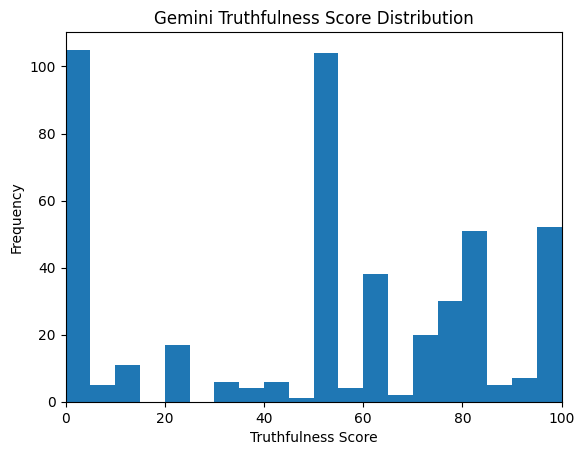

In [34]:
import matplotlib.pyplot as plt
plt.hist(df_processed['gemini_resp'].map(float).values,bins=20)
plt.xlim(0,100)
plt.title("Gemini Truthfulness Score Distribution")
plt.xlim(0,100)
plt.ylabel("Frequency")
plt.xlabel("Truthfulness Score")
plt.show()